In [3]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [4]:
# global variables
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define data directories
dataset_path  = "C:\\Users\\sangeetha\\1\\Bone_Fracture_Binary_Classification\\Bone_Fracture_Binary_Classification"

train_path = "C:\\Users\\sangeetha\\1\\Bone_Fracture_Binary_Classification\\Bone_Fracture_Binary_Classification\\train"
test_path = "C:\\Users\\sangeetha\\1\\Bone_Fracture_Binary_Classification\\Bone_Fracture_Binary_Classification\\test"
val_path="C:\\Users\\sangeetha\\1\\Bone_Fracture_Binary_Classification\\Bone_Fracture_Binary_Classification\\val"


# Load image paths
train_paths = glob(f"{train_path}/*/*.png") + glob(f"{train_path}/*/*.jpeg") + glob(f"{train_path}/*/*.jpg")
val_paths = glob(f"{val_path}/*/*.png") + glob(f"{val_path}/*/*.jpeg")+ glob(f"{val_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.png") + glob(f"{test_path}/*/*.jpeg")+glob(f"{test_path}/*/*.jpg")



In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
# check device
device

'cpu'

In [7]:

# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
from torch.utils.data import Dataset
from PIL import Image, ImageFile

# Allow truncated images to be loaded
ImageFile.LOAD_TRUNCATED_IMAGES = True

class dataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.labels_to_index = {label: idx for idx, label in enumerate(set(labels))}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img_path = self.paths[index]
        
        # Try loading the image, handle any corruption gracefully
        try:
            img = Image.open(img_path).convert('RGB')
        except (IOError, OSError):
            print(f"Skipping corrupted image: {img_path}")
            return self.__getitem__((index + 1) % len(self.paths))  # Load the next image

        label = self.labels[index]
        label_index = self.labels_to_index[label]

        if self.transform:
            img = self.transform(img)

        return img, label_index, label


In [15]:
train_dataset = dataset(train_paths, transform=train_transform)
val_dataset = dataset(val_paths, transform=test_transform)
test_dataset = dataset(test_paths, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Final Train images: {len(train_dataset)}")
print(f"Final Validation images: {len(val_dataset)}")
print(f"Final Test images: {len(test_dataset)}")


Final Train images: 9246
Final Validation images: 829
Final Test images: 506


In [ ]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset=dataset(val_paths, transform=test_transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
print(f"Train images found: {len(train_paths)}")
print(f"Test images found: {len(test_paths)}")
print(f"Validation images found: {len(val_paths)}")


Train images found: 9246
Test images found: 506
Validation images found: 829


In [15]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

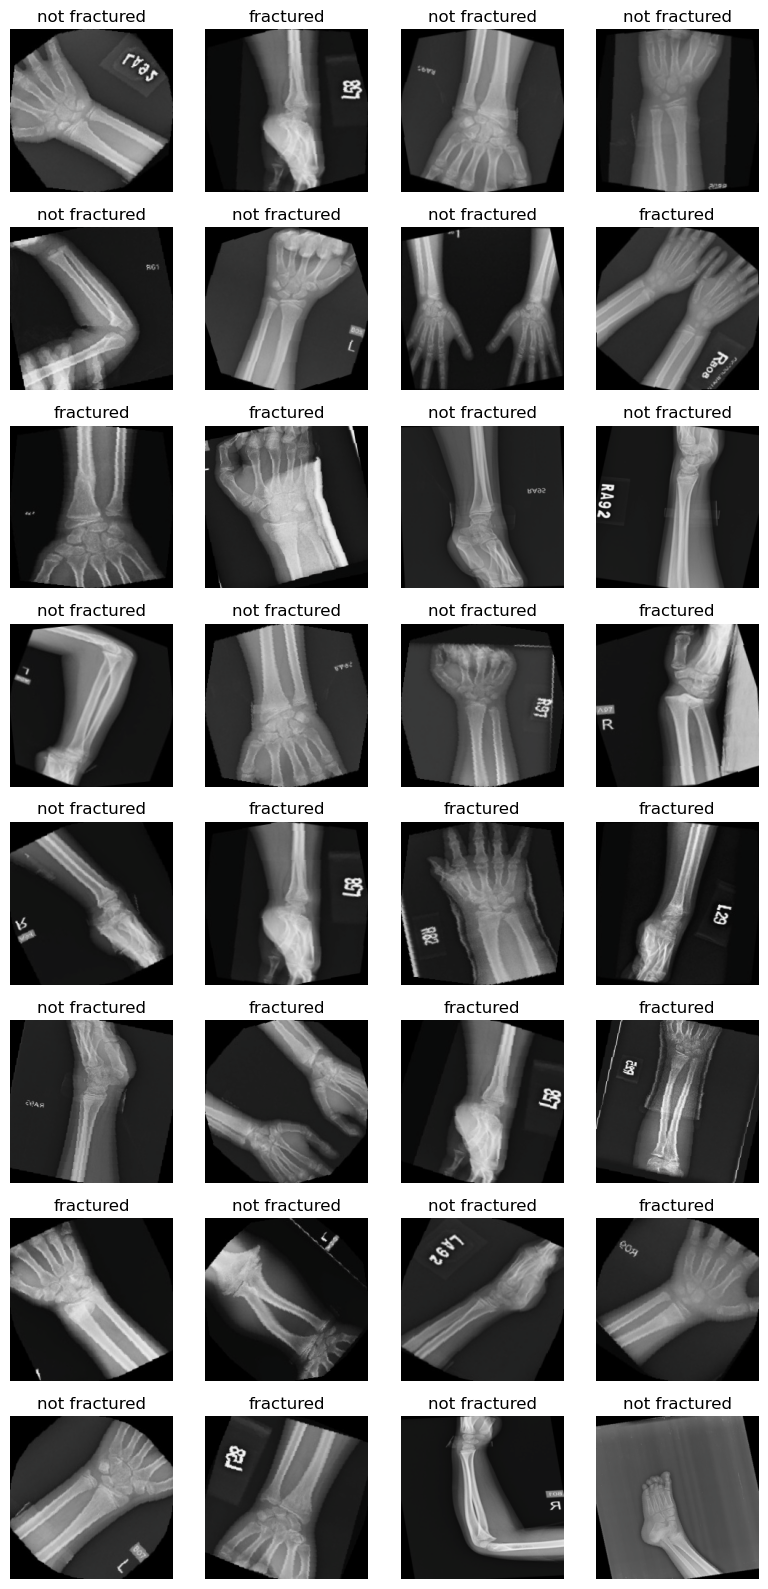

In [16]:
# display sample images with classes
train_iter = iter(train_loader)
images, labels_indices, labels = next(train_iter)

def imshow(input_images, labels_indices,labels):
    label_dict = {"fractured":"fractured", "not fractured":"not fractured"}
    input_images=input_images.numpy().transpose((0,2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_images = std * input_images + mean
    input_images = np.clip(input_images, 0, 1)
    fig, axes = plt.subplots(8, 4, figsize=(8, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(input_images[i])
        ax.axis('off')
        ax.set_title(label_dict[labels[i]], fontsize=12)
    plt.tight_layout()
    plt.show()


imshow(images, labels_indices,labels)

In [17]:
# Get unique labels
unique_labels = set(train_dataset.labels)  # Extract unique labels from the training dataset
print("Class Labels:", unique_labels)


Class Labels: {'fractured', 'not fractured'}


In [18]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [19]:
num_classes=2
model = MyModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)

In [23]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [24]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [25]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [26]:
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"bone_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

Epoch 0,   Batch 150/289, Loss: 0.2123, Accuracy: 92.14%


C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1938, Train Accuracy: 92.74%
Eval Loss: 0.2434, Eval Accuracy: 90.47%
######################################################################
Epoch 1,   Batch 150/289, Loss: 0.1218, Accuracy: 95.49%
Train Loss: 0.1182, Train Accuracy: 95.72%
Eval Loss: 0.2329, Eval Accuracy: 92.64%
######################################################################
Epoch 2,   Batch 150/289, Loss: 0.0903, Accuracy: 96.98%
Train Loss: 0.0850, Train Accuracy: 97.25%
Eval Loss: 0.3224, Eval Accuracy: 88.54%
######################################################################
Epoch 3,   Batch 150/289, Loss: 0.0657, Accuracy: 97.72%
Train Loss: 0.0649, Train Accuracy: 97.93%
Eval Loss: 0.1460, Eval Accuracy: 95.17%
######################################################################
Epoch 4,   Batch 150/289, Loss: 0.0536, Accuracy: 98.28%
Train Loss: 0.0520, Train Accuracy: 98.20%
Eval Loss: 0.2020, Eval Accuracy: 94.93%
####################################################################

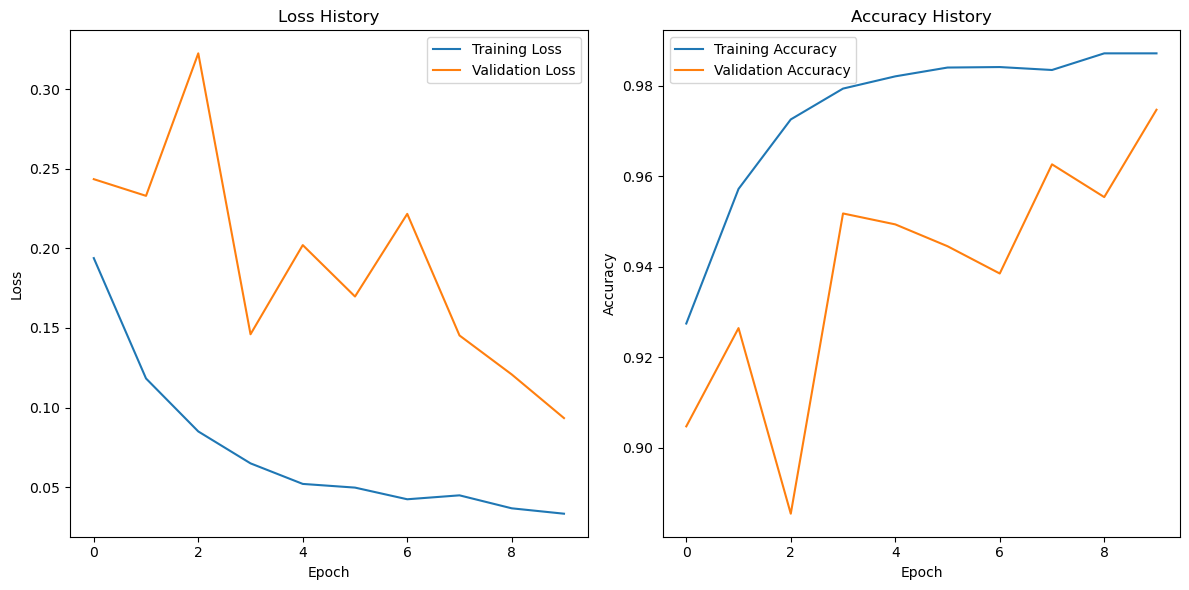

In [27]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In [28]:
models = glob("C:\\Users\\sangeetha\\bone_*")
print("Found models:", models)

Found models: ['C:\\Users\\sangeetha\\bone_1', 'C:\\Users\\sangeetha\\bone_10', 'C:\\Users\\sangeetha\\bone_2', 'C:\\Users\\sangeetha\\bone_4', 'C:\\Users\\sangeetha\\bone_8', 'C:\\Users\\sangeetha\\bone_9', 'C:\\Users\\sangeetha\\bone_fracture.ipynb']


In [32]:

# Extract only numeric model numbers
model_num = [
    int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()
]

if model_num:
    best_model_path = "C:\\Users\\sangeetha\\bone_" + str(max(model_num))
    print("Best model path:", best_model_path)
else:
    print("No valid numeric model files found.")

Best model path: C:\Users\sangeetha\bone_10


In [33]:
best_model = MyModel(num_classes).to(device)

best_model.load_state_dict(torch.load(best_model_path, map_location=device))

C:\Users\sangeetha\AppData\Local\Temp\ipykernel_12116\1382705795.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path, m

<All keys matched successfully>

In [34]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predictions.append(y_pred.cpu().numpy())
        
    return np.vstack(predictions)

In [35]:
best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)
best_model_preds.shape[0]

506

In [36]:
gen_labels_test_set = [label[1] for label in test_dataset]
len(gen_labels_test_set)

506

In [37]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")


Best Model Test Accuracy: 98.02%


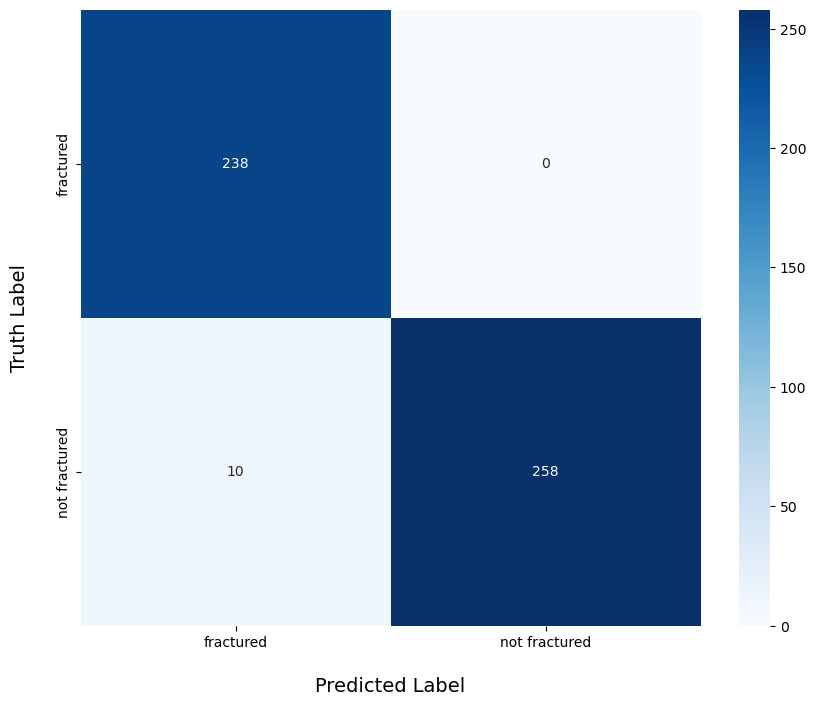

In [38]:
cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = set([label[2] for label in test_dataset])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()

In [39]:
model = MyModel(num_classes).to(device)
model.load_state_dict(torch.load("C:\\Users\\sangeetha\\bone_10"))  # Replace with the correct model file name
model.eval()  # Set the model to evaluation mode


C:\Users\sangeetha\AppData\Local\Temp\ipykernel_12116\2200610229.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:\\Users\\sangeetha\\

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, in

In [41]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open and convert to RGB
    image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
    return image.to(device)


In [40]:
# Get unique labels
unique_labels = set(train_dataset.labels)  # Extract unique labels from the training dataset
print("Class Labels:", unique_labels)


Class Labels: {'fractured', 'not fractured'}


In [42]:
label_dict = {
    
    0:"fractured",
    1: "not fractured",
  
  
}

def predict(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class index
    return label_dict[predicted.item()]  # Return the class name


In [45]:
image_path = "C:\\Users\\sangeetha\\1\\Bone_Fracture_Binary_Classification\\dataset\\Bone_Fracture_Binary_Classification\\test\\fractured\\2-rotated2-rotated3 - Copy.jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")


Predicted  Type: fractured


In [46]:
image_path = "C:\\Users\\sangeetha\\1\\Bone_Fracture_Binary_Classification\\dataset\\Bone_Fracture_Binary_Classification\\test\\not fractured\\2.png"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")


Predicted  Type: not fractured


In [47]:

image_path = "C:\\Users\\sangeetha\\1\\Bone_Fracture_Binary_Classification\\dataset\\Bone_Fracture_Binary_Classification\\val\\fractured\\2-rotated1-rotated2-rotated3.jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")


Predicted  Type: fractured


In [48]:


image_path = "C:\\Users\\sangeetha\\1\\Bone_Fracture_Binary_Classification\\dataset\\Bone_Fracture_Binary_Classification\\val\\not fractured\\1-rotated3.jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")


Predicted  Type: not fractured


In [49]:
image_path = "Downloads\\OIP (4).jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")


Predicted  Type: fractured


In [50]:
image_path = "Downloads\\OIP (5).jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")


Predicted  Type: fractured


In [51]:
image_path = "Downloads\\4d83d807fe7af170aa25b936567aa7e4.jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")


Predicted  Type: fractured


In [52]:
image_path = "Downloads\\OIP (6).jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")

Predicted  Type: fractured
